In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy.stats import rankdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
# import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.manifold import TSNE

import shap

import seaborn as sns

from sklearn.model_selection import StratifiedKFold,KFold
import warnings
warnings.filterwarnings(action='ignore')

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
pd.set_option('display.max_columns', None)
warnings.filterwarnings(action='ignore')

# Function

In [7]:
# this function return submission file with 15 top feature for each row model use to make a predict
def submission(model,test,preds):
    '''
    make return submission with 15 feature 
    '''
    print('shape value..')
    expaliner = shap.TreeExplainer(model)
    shap_values = expaliner.shap_values(test)

    features = test.columns
    f = {
        'f1' : [], 'f2': [], 'f3': [], 'f4': [],'f5': [],
        'f6' : [], 'f7': [], 'f8': [], 'f9': [],'f10': [],
        'f11' : [], 'f12': [], 'f13': [], 'f14': [],'f15': []
    }
    print('submission..')
    for shap_value in shap_values:
        arr = np.argsort(shap_value)[::-1][:15]
        for ind, a in enumerate(arr):
            name_f = f'f{ind+1}'
            f[name_f].append(features[a])
    sub = pd.DataFrame()
    sub['child_id'] = ID
    sub['target']  = preds

    for i in range(1,16):
        sub[f'feature_{i}'] = f[f'f{i}'] 
    return sub

#Plot the Features Importances
def plotImp(model, X , num = 20, fig_size = (10, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    sns.set()

# this function return missin value in train,test
def missing_data(train,test,num=20):
    '''
    this function return missin value in train,test
    '''
    print(f' train shape {train.shape} and test shape{test.shape}:')
    total = train.isnull().sum().sort_values(ascending=False)
    percent_1 = train.isnull().sum()/train.isnull().count()*100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data_train= pd.concat([total, percent_2], axis=1, keys=['train_missing', '%'])

    #missing data percentage (test Data)
    total = test.isnull().sum().sort_values(ascending=False)
    percent_1 = test.isnull().sum()/test.isnull().count()*100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data_test = pd.concat([total, percent_2], axis=1, keys=['test missing', '%'])

    missing_train_test = pd.concat([missing_data_train, missing_data_test], axis=1)
    return missing_train_test[:num]

# this function delet missing value by base a precentege like 89% in adata and return dataframe with delete column that match a precentage
def dell_missing(percentage,train,test):
    perc = percentage
    min_count =  int(((100-perc)/100)*train.shape[0] + 1)
    train = train.dropna(axis=1, thresh=min_count)
    min_count =  int(((100-perc)/100)*test.shape[0] + 1)
    test = test.dropna(axis=1, thresh=min_count)
    return train,test

# Data & EDA

<b> the data is 600 feature, all feature is not importance and other can get a model warse, hence I use LOFO to select 40 feature from 600\
see note book here  [LOFO DataDrive2030 Early Learning Predictors Challenge](https://github.com/aerdem4/lofo-importance)\
!!`Note` [LOFO](https://github.com/aerdem4/lofo-importance) tak a lot off time in kaggle kernel with `GPU` and take 5 hour to end</b>

In [17]:
# All Data after select feature
feat  = ['child_id','child_age','language_child','child_observe_total','id_enumerator',
        'child_date','count_register_gender_female','count_register_gender_male','count_register_gender','count_children_attendance',
        'child_observe_attentive','child_gender','child_observe_concentrated', 'child_observe_diligent',
       'child_years_in_programme','teacher_emotional_total','ses_proxy','obs_accessible','pri_kitchen',
        'count_staff_salary','latitude','longitude','count_children_present','dc_best', 'id_mn_best','id_ward','id_prov',
       'language_assessment', 'obs_area','obs_handwashing_2','id_dc_best','child_height','pri_bank','pra_free_play',
       'pri_language','prov_best', 'ses_cat','teacher_emotional_independent','teacher_social_peers', 'teacher_emotional_met','teacher_emotional_understand', 'teacher_social_assistance',
       'target']

train = pd.read_csv('/kaggle/input/datadrive2030-early-learning-predictors-challenge/Train.csv')[feat]
test = pd.read_csv('/kaggle/input/datadrive2030-early-learning-predictors-challenge/Test.csv')[feat[:-1]]
ID = test.child_id
# concat data to preprocessing all
df = pd.concat([train,test],axis=0).reset_index(drop=True)

In [23]:
df.select_dtypes(include='object').columns

Index(['child_id', 'language_child', 'child_date', 'child_observe_attentive',
       'child_gender', 'child_observe_concentrated', 'child_observe_diligent',
       'child_years_in_programme', 'obs_accessible', 'pri_kitchen', 'dc_best',
       'id_mn_best', 'id_prov', 'language_assessment', 'obs_area',
       'obs_handwashing_2', 'id_dc_best', 'pri_bank', 'pra_free_play',
       'pri_language', 'prov_best', 'ses_cat', 'teacher_emotional_independent',
       'teacher_social_peers', 'teacher_emotional_met',
       'teacher_emotional_understand', 'teacher_social_assistance'],
      dtype='object')

In [18]:
display(df.select_dtypes(include='object'),df.select_dtypes(include='number'))

,child_id,language_child,child_date,child_observe_attentive,child_gender,child_observe_concentrated,child_observe_diligent,child_years_in_programme,obs_accessible,pri_kitchen,dc_best,id_mn_best,id_prov,language_assessment,obs_area,obs_handwashing_2,id_dc_best,pri_bank,pra_free_play,pri_language,prov_best,ses_cat,teacher_emotional_independent,teacher_social_peers,teacher_emotional_met,teacher_emotional_understand,teacher_social_assistance
0,ID_SYSJ2FM0D,Sesotho,2022-02-03,Sometimes,Female,Sometimes,Sometimes,NaN,NaN,NaN,SEDIBENG,GT421,GT,Sesotho,NaN,NaN,DC42,NaN,NaN,NaN,GAUTENG,NaN,NaN,NaN,Does not meet standard,NaN,NaN
1,ID_J5BTFOZR3,isiZulu,NaN,Sometimes,Female,Almost never,Sometimes,1st year in the programme,NaN,NaN,UMGUNGUNDLOVU,NaN,KZN,isiZulu,NaN,NaN,DC22,NaN,NaN,NaN,KWAZULU-NATAL,NaN,NaN,NaN,Does not meet standard,NaN,NaN
2,ID_R00SN7AUD,Afrikaans,2022-03-11,Often,Male,Often,Sometimes,NaN,NaN,NaN,CITY OF CAPE TOWN,CPT,WC,Afrikaans,NaN,NaN,CPT,NaN,NaN,NaN,WESTERN CAPE,R0-110,Sometimes True,Most of the time,NaN,Often True,None of the time
3,ID_BSSK60PAZ,isiXhosa,2021-10-13,Almost always,Male,Almost always,Sometimes,1st year in the programme,Yes,Yes,CAPE WINELANDS,WC025,WC,isiXhosa,1 4 6,No,DC2,Yes,Up to 1 hour,2 4,WESTERN CAPE,R291-750,Often True,Most of the time,Meets the standard,Often True,All of the time
4,ID_IZTY6TC4D,isiZulu,2021-10-13,Almost always,Female,Almost always,Almost always,2nd year in programme,Yes,Yes,ILEMBE,KZN293,KZN,isiZulu,1 2 3 4,No,DC29,Yes,30 minutes or less,5,KWAZULU-NATAL,R0-110,Often True,All of the time,Meets the standard,Often True,All of the time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12260,ID_LBPQ2VMQZ,NaN,2022-11-18,Often,Male,Often,Sometimes,2nd year in programme,NaN,NaN,NaN,NaN,NaN,English,NaN,NaN,NaN,NaN,NaN,NaN,GAUTENG,NaN,NaN,NaN,NaN,NaN,NaN
12261,ID_H2RKKMMKK,Afrikaans,2021-11-10,Sometimes,Female,Sometimes,Sometimes,1st year in the programme,No,Yes,CITY OF CAPE TOWN,CPT,WC,Afrikaans,1 2 3 4 5 6 7 8,No,CPT,Yes,30 minutes or less,1,WESTERN CAPE,R291-750,NaN,NaN,Does not meet standard,NaN,NaN
12262,ID_VY8KX7YTZ,Afrikaans,2021-10-29,Almost always,Female,Almost always,Almost always,1st year in the programme,Yes,Yes,Z F MGCAWU,NC084,NC,Afrikaans,1 3 7,No,DC8,Yes,Up to 1 hour,1,NORTHERN CAPE,R0-110,NaN,NaN,NaN,NaN,NaN
12263,ID_EO2MYZ4M7,Setswana,2021-09-23,Sometimes,Female,Sometimes,Almost never,1st year in the programme,Yes,Yes,BOJANALA,NW375,NW,Setswana,1 2 5,No,DC37,Yes,30 minutes or less,2 7,NORTH WEST,R111-290,Sometimes True,A little of the time,Does not meet standard,Often True,None of the time


,child_age,child_observe_total,id_enumerator,count_register_gender_female,count_register_gender_male,count_register_gender,count_children_attendance,teacher_emotional_total,ses_proxy,count_staff_salary,latitude,longitude,count_children_present,id_ward,child_height,target
0,59.000000,4.0,20005.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,-26.551048,27.879824,NaN,74201039.0,NaN,51.500000
1,60.163933,4.0,NaN,NaN,NaN,NaN,NaN,7.0,4.0,NaN,NaN,NaN,NaN,NaN,103.000000,55.869999
2,69.000000,7.0,20001.0,NaN,NaN,NaN,NaN,9.0,1.0,NaN,NaN,NaN,NaN,19100085.0,108.400002,47.520000
3,53.000000,9.0,2689.0,21.0,17.0,38.0,38.0,12.0,3.0,5.0,-33.664103,19.543337,30.0,10205018.0,98.099998,58.599998
4,57.000000,12.0,542.0,16.0,11.0,27.0,20.0,12.0,1.0,0.0,-29.457600,30.969100,17.0,52903010.0,114.000000,76.599998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12260,67.318275,8.0,158.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,-25.962204,28.095118,NaN,NaN,NaN,NaN
12261,64.000000,4.0,20012.0,24.0,18.0,42.0,42.0,NaN,3.0,5.0,-33.782218,18.713655,40.0,19100105.0,112.000000,NaN
12262,59.000000,12.0,2679.0,20.0,15.0,35.0,12.0,NaN,1.0,3.0,-28.896010,21.988810,6.0,30804006.0,108.000000,NaN
12263,52.000000,2.0,567.0,29.0,24.0,53.0,43.0,5.0,2.0,6.0,-25.132220,26.656530,43.0,63705003.0,106.000000,NaN


# EDA

In [11]:
# get numerical data and categorical data
num_fet = df.select_dtypes(include='number').columns
cat_fet = df.select_dtypes(include='object').columns

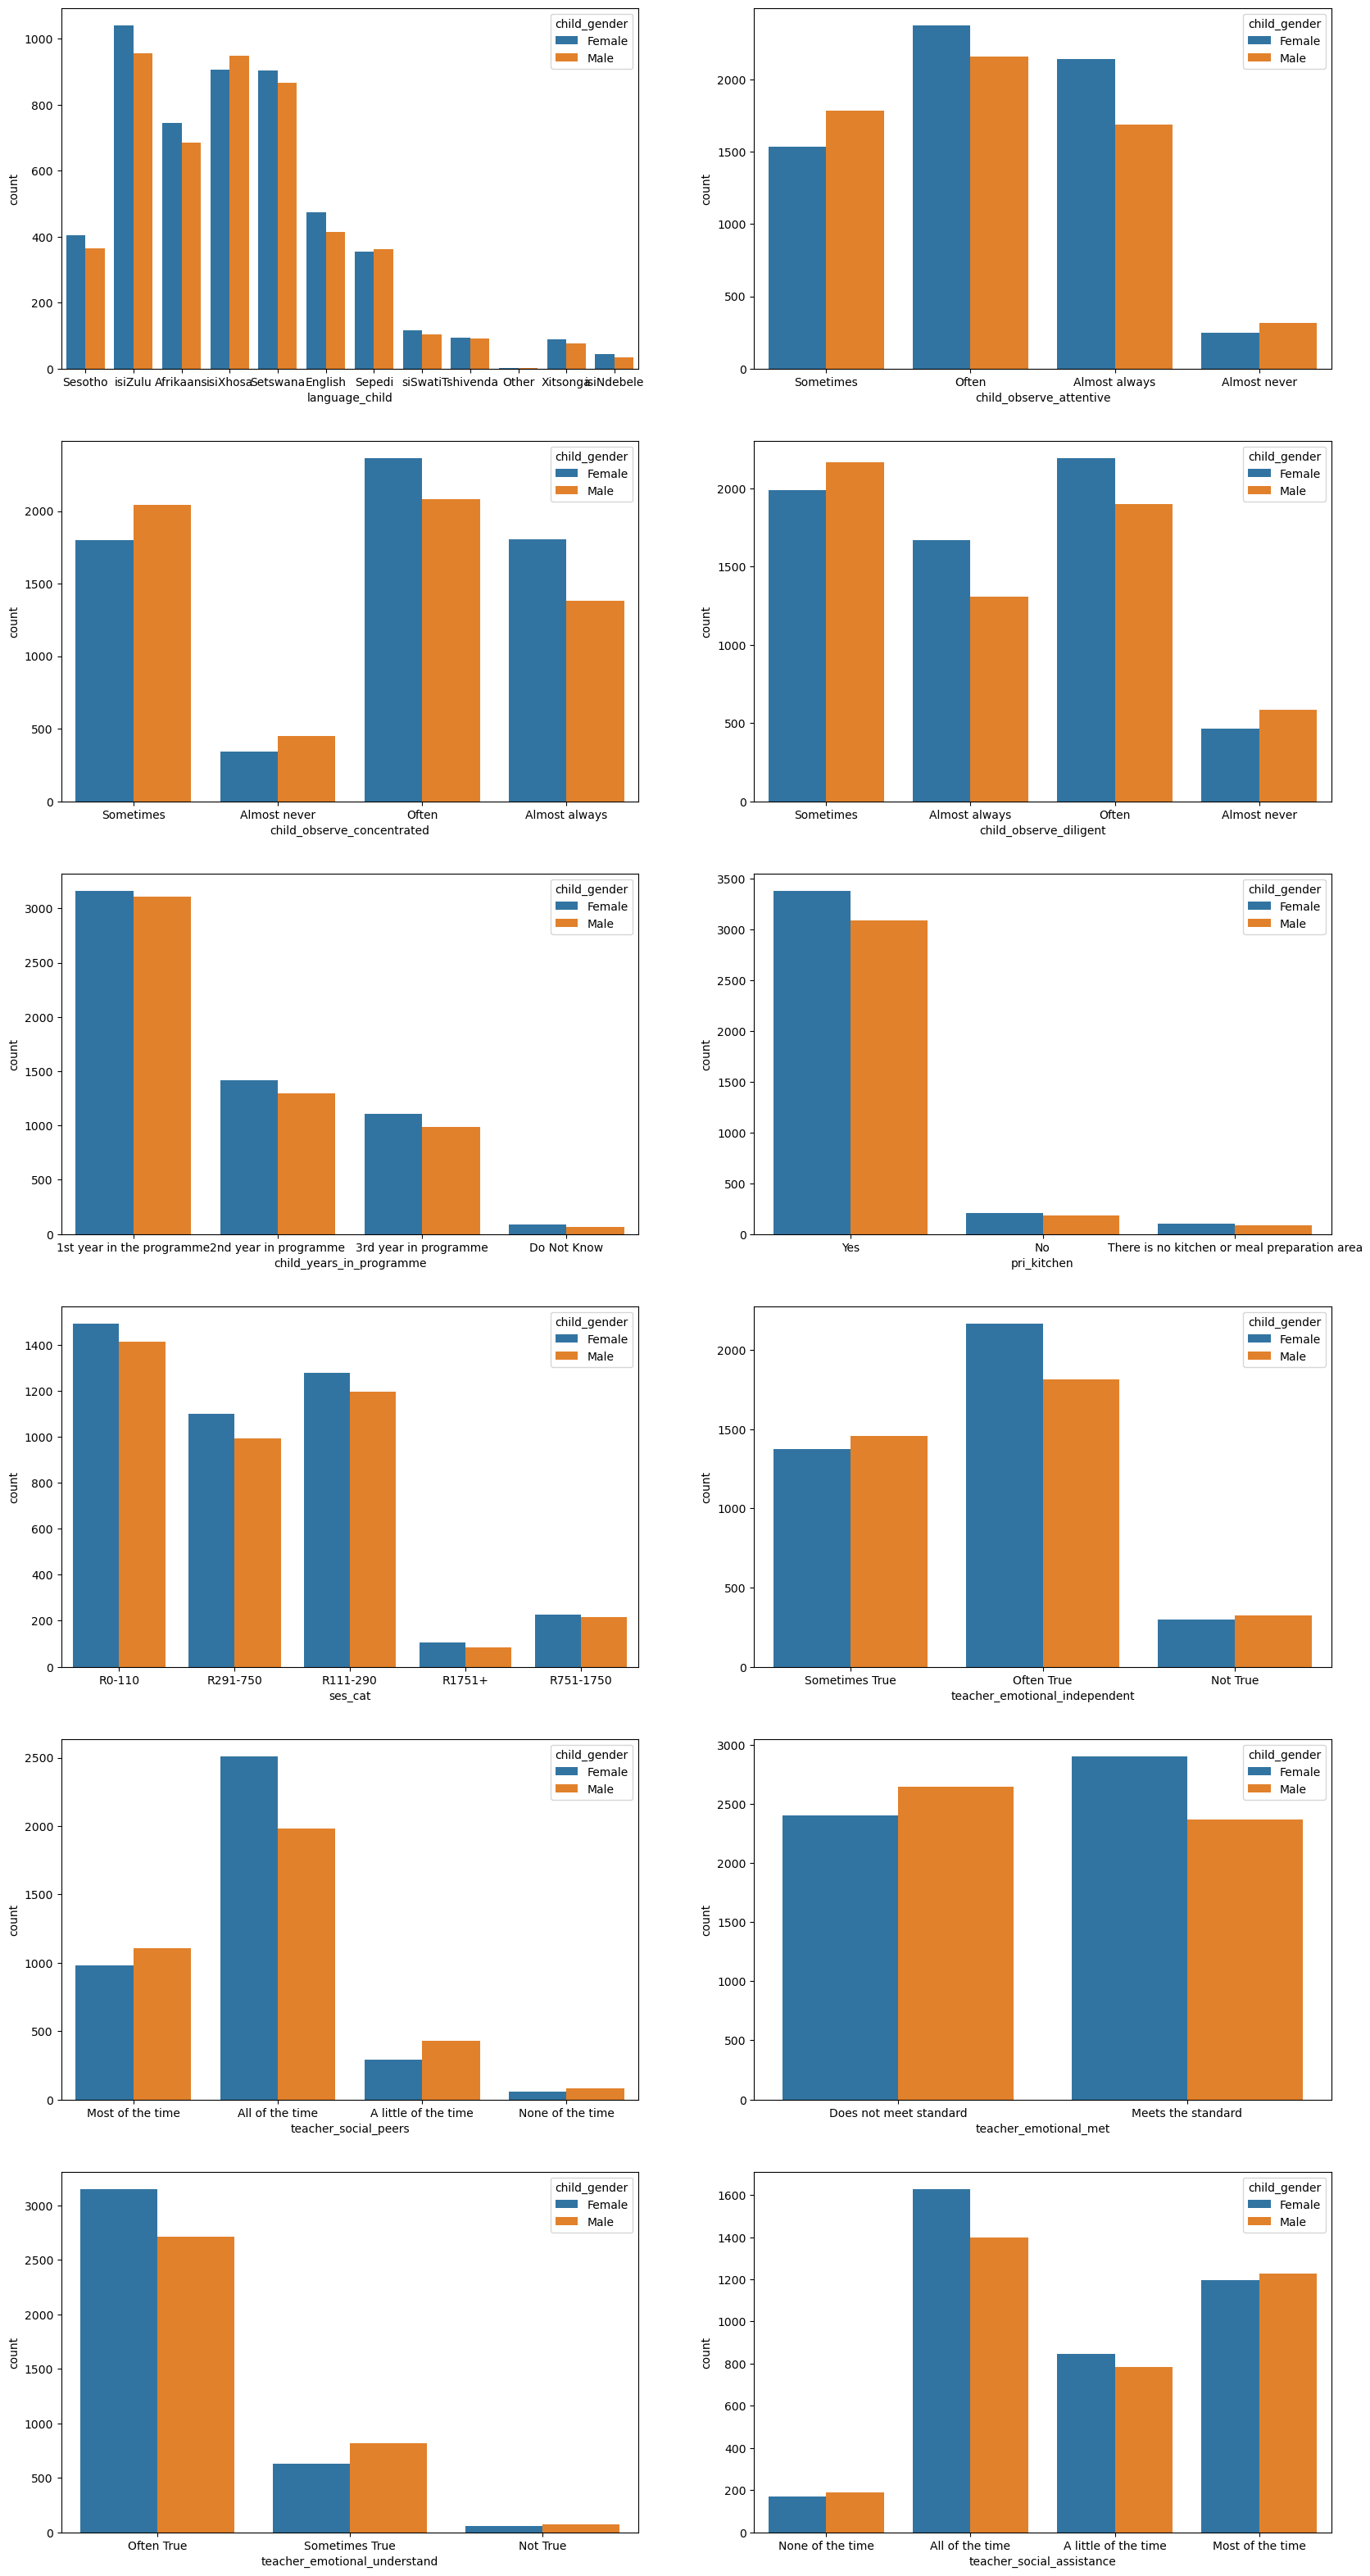

In [27]:
cot_col = ['language_child','child_observe_attentive','child_observe_concentrated','child_observe_diligent','child_years_in_programme','pri_kitchen','ses_cat','teacher_emotional_independent','teacher_social_peers','teacher_emotional_met','teacher_emotional_understand','teacher_social_assistance']
n_rows=6
n_cols=2
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(20,40))
for i, column in enumerate(cot_col):
    sns.countplot(data = df,x=column,ax=axes[i//n_cols,i%n_cols],hue="child_gender")

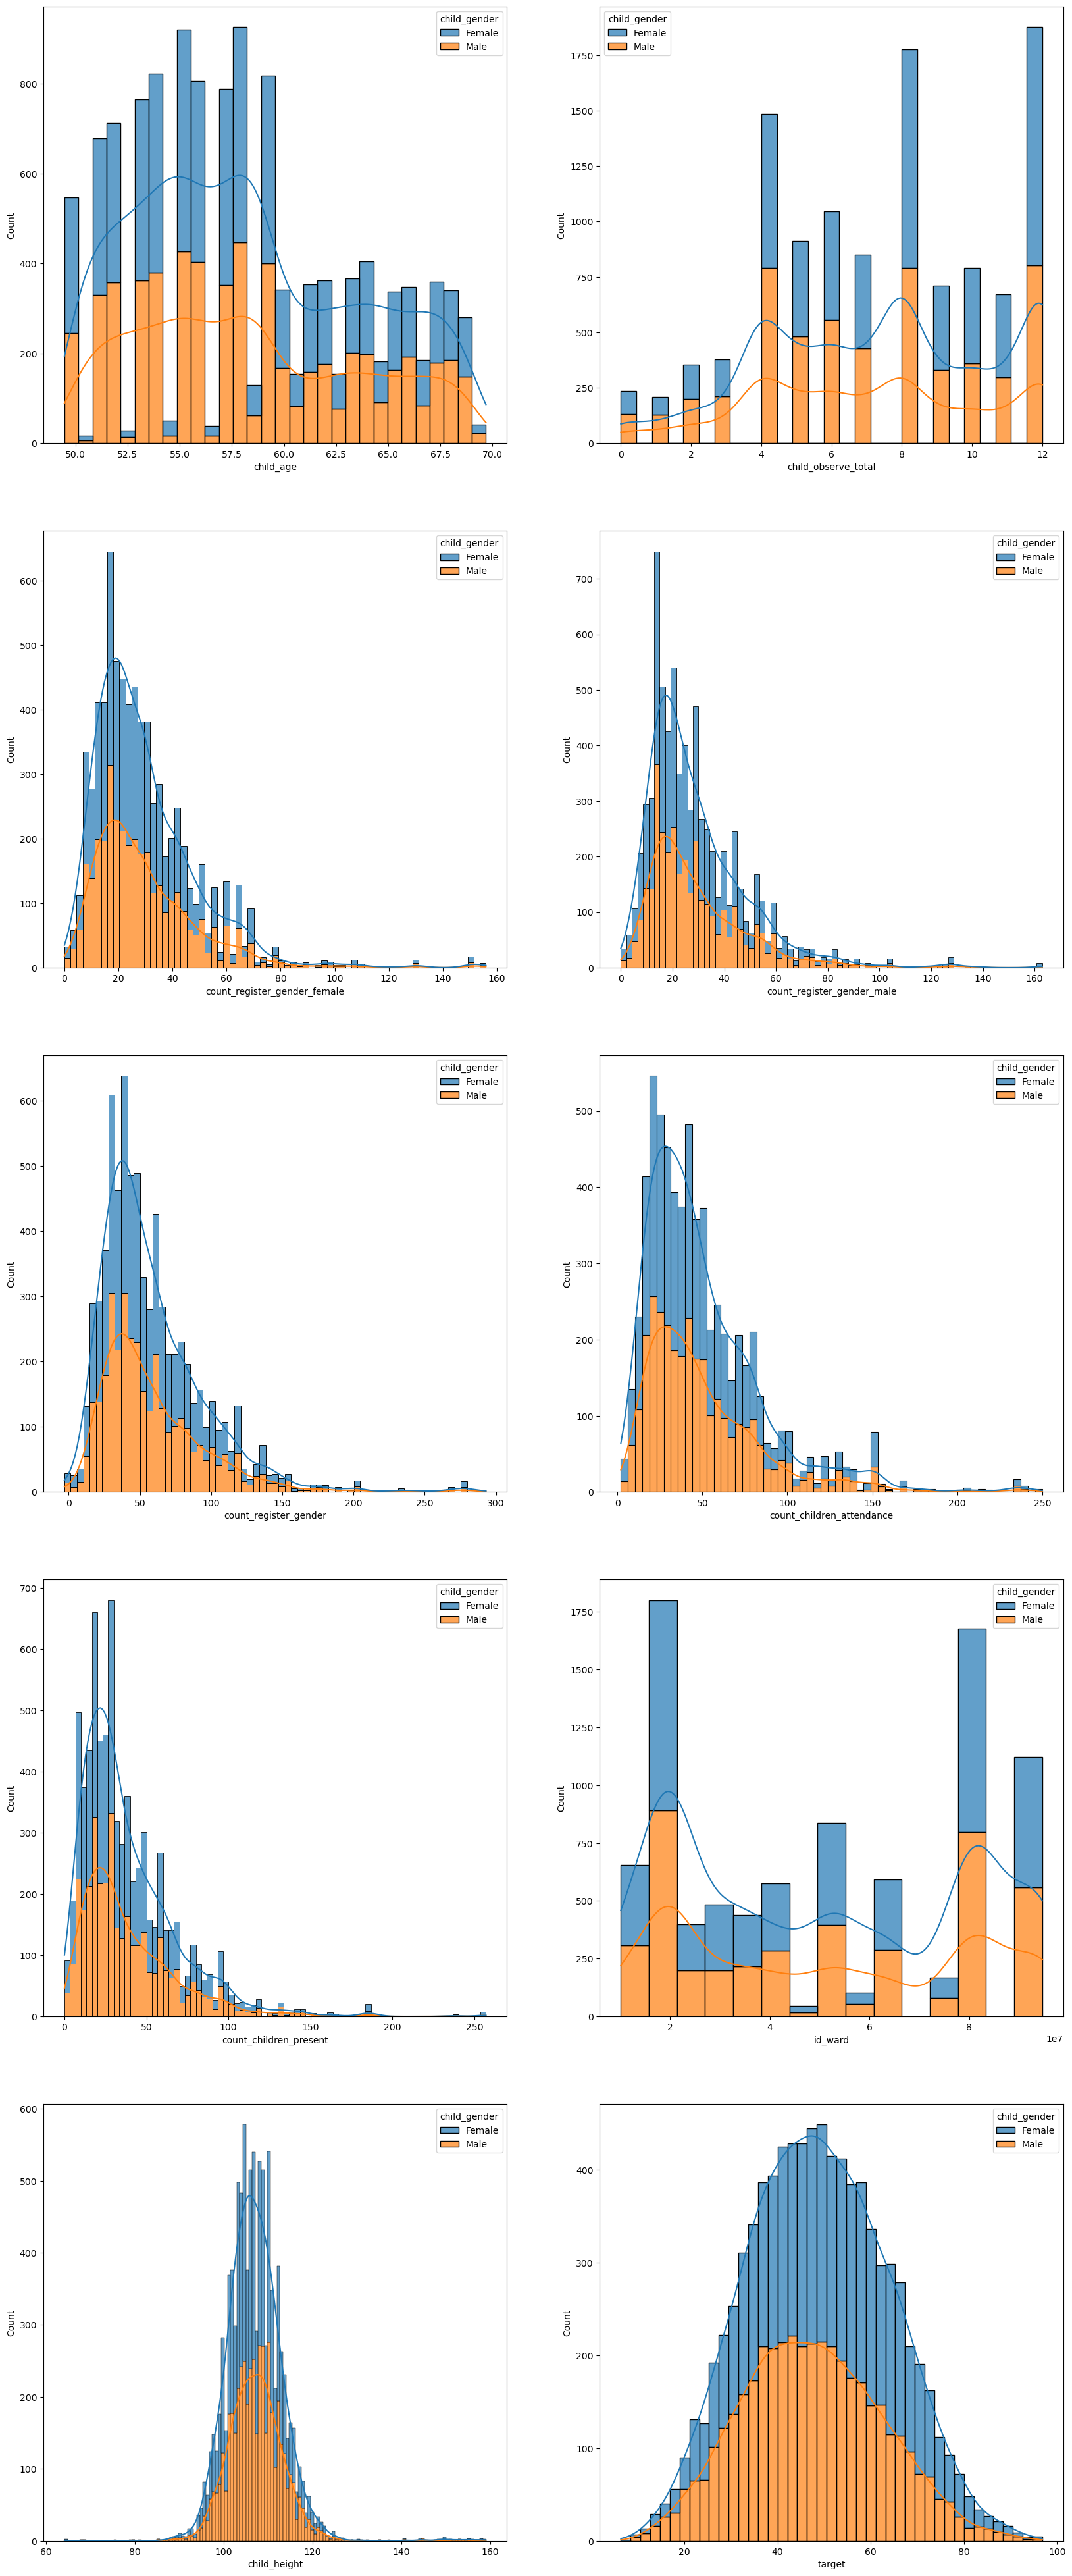

In [32]:
len(cat_fet)
n_rows=5
n_cols=2
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(20,50))
num_fet = df.drop(['id_enumerator','ses_proxy','latitude','longitude','teacher_emotional_total','count_staff_salary'],axis=1).select_dtypes(include='number').columns
coll = df[num_fet].columns
for i, column in enumerate(coll):
    sns.histplot(data = df,x=column,ax=axes[i//n_cols,i%n_cols],kde=True,hue='child_gender',alpha=0.7,multiple="stack")

## coordination

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

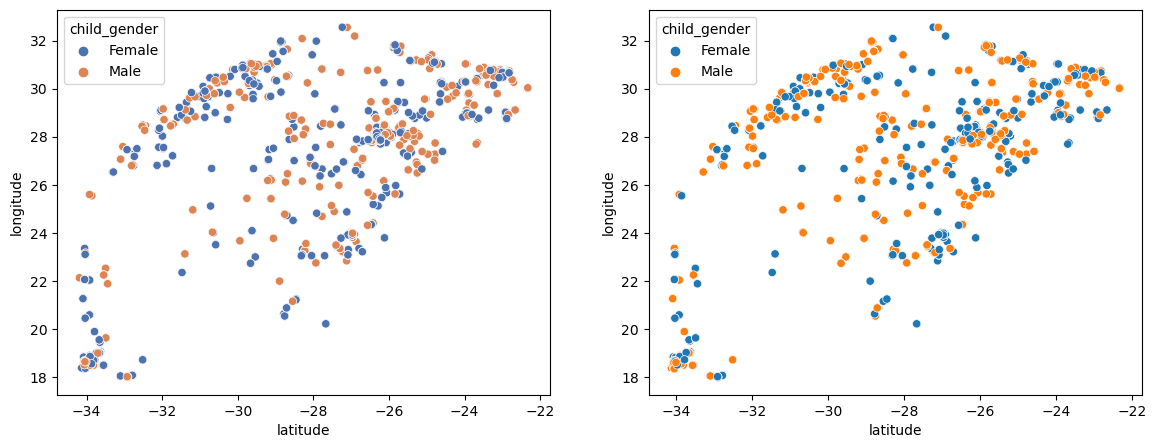

In [57]:
# Create the subplots
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,5))
sns.scatterplot(data=train,x='latitude',y ='longitude',ax=axes[0],c='red',hue="child_gender",palette="deep")
sns.scatterplot(data=test,x='latitude',y ='longitude',ax=axes[1],c='orange',hue="child_gender")

so far so good the location is simillar in both train and test

# Feature Engineering and Feature Generation

In [ ]:
# concat lat and long to get simillar place in both train and test
df['Place'] = (df['latitude'] + df['longitude']).round()
df.drop(['latitude','longitude'],axis=1,inplace=True)

# For how many years has this child been in the programme there are some missing valeu fillit with Do Not Know
df['child_years_in_programme'].fillna('Do Not Know',inplace=True)
df['child_years_in_programme_map'] = df['child_years_in_programme'].map({'1st year in the programme':1,'2nd year in programme':2,'3rd year in programme':3,'Do Not Know':0})

# Emotional Readiness for School  fill it with not know
df['teacher_emotional_met'].fillna('not Know',inplace=True)
df['grade'] = (df['child_observe_total']//4).map({4:'A',3:'B',2:'c',1:'d'})


df['id_ward_enc'] = df['id_ward'].astype(str).str[:-6]
df['id_ward_enc'].loc[df['id_ward_enc']==''] = np.NAN

df['id_enumerator_enc'] = df['id_enumerator'].astype(str).str[:-4]
df['id_enumerator_enc'].loc[df['id_enumerator_enc']==''] = np.NAN

df['child_date_en'] = df['child_date'].astype(str).str[:8]
df['child_date_en'].loc[df['child_date_en']=='nan'] = np.NAN

df['ses_proxy_fillid'] = df['ses_proxy'].fillna(2)
df['teacher_emotional_met'].fillna('not Now',inplace=True)

## feature interaction

In [ ]:
for feat_1 in ['child_age']:
    for feat_2 in ['child_observe_total', 'teacher_emotional_total','child_years_in_programme_map','child_height']:
        df[f'Sum_{feat_1}_{feat_2}'] = df[feat_1] + df[feat_2]
        df[f'Subtract_{feat_1}_{feat_2}'] = df[feat_1] - df[feat_2]
        df[f'Product_{feat_1}_{feat_2}'] = df[feat_1] * df[feat_2]
        df[f'Division_{feat_1}_{feat_2}'] = df[feat_1] / (df[feat_2]+1)
    
#  Total: Teacher Emotional with Total score from observing the child during assessments
for feat_1 in ['teacher_emotional_total']:
    for feat_2 in ['child_observe_total']:
        df[f'Sum_{feat_1}_{feat_2}'] = df[feat_1] + df[feat_2]
        df[f'Subtract_{feat_1}_{feat_2}'] = df[feat_1] - df[feat_2]
        df[f'Product_{feat_1}_{feat_2}'] = df[feat_1] * df[feat_2]
        df[f'Division_{feat_1}_{feat_2}'] = df[feat_1] / (df[feat_2]+1)
    

## Aggregation

In [ ]:
# first round age to aggregation
df['child_age_groubed'] = df['child_age'].round(1)

ft = ['Place','id_enumerator','child_date','child_age_groubed','child_observe_concentrated','child_observe_diligent','child_observe_attentive']
ft2 = ['child_observe_total','teacher_emotional_total','child_height','ses_proxy']
for vl in ft:
    for fet_ in ft2:
        df[vl+f'_mean_'+fet_+'_Aggregation'] = df.groupby(vl)[fet_].transform(lambda x: x.mean())
        df[vl+f'_min_'+fet_+'_Aggregation'] = df.groupby(vl)[fet_].transform(lambda x: x.min())
        df[vl+f'_max_'+fet_+'_Aggregation'] = df.groupby(vl)[fet_].transform(lambda x: x.max())
        df[vl+f'_std_'+fet_+'_Aggregation'] = df.groupby(vl)[fet_].transform(lambda x: x.std())
        
        df[vl+f'_first_'+fet_+'_Aggregation'] = df[vl].map(dict(df.groupby(vl)[fet_].first()))
        df[vl+f'_last_'+fet_+'_Aggregation'] = df[vl].map(dict(df.groupby(vl)[fet_].last()))
        df[vl+f'_Range_'+fet_+'_Aggregation'] = (df[vl+f'_max_'+fet_+'_Aggregation'] - df[vl+f'_min_'+fet_+'_Aggregation'])
        df[vl+f'_skew_'+fet_+'_Aggregation'] = df.groupby(vl)[fet_].transform(lambda x: x.skew())

## mean encoding
this mean encoding give me very boost in lb but should carefull `data leakage`

In [ ]:
mean_enc_col = ['id_enumerator','child_date_en','id_ward','child_years_in_programme_map','child_years_in_programme_map','Place','teacher_emotional_met']
for col in mean_enc_col:
    mean = df.groupby(col).target.mean()
    df[f'{col}_mean_encoding'] = df[col].map(mean)
    std = df.groupby(col).target.std()
    df[f'{col}_std_encoding'] = df[col].map(std)
    skew = df.groupby(col).target.skew()
    df[f'{col}_skew_encoding'] = df[col].map(skew)
    percental25 = df.groupby(col).target.quantile(q=.25)
    df[f'{col}_Percental_25_encoding'] = df[col].map(percental25)
    percental75 = df.groupby(col).target.quantile(q=.75)
    df[f'{col}_Percental_75_encoding'] = df[col].map(percental75)
    

## (frequency & count & categoical) Encoding

In [ ]:
f_en = ['child_observe_diligent', 'child_observe_attentive','prov_best','language_assessment','child_observe_concentrated','child_years_in_programme_map','ses_proxy_fillid']
for col in f_en:
    enc_nom_1 = (df.groupby(col).size()) / len(df)
    df[col+'_encode_frequency'] = df[col].apply(lambda x : enc_nom_1[x])
    # count encoding
    map_df = df[col].value_counts().to_dict()
    df[col+'_encoding_count']= df[col].map(map_df)
    

# categorical  aggregatiojn
for vl in ['id_enumerator']:
    for fet_ in f_en:
        df[vl+'_'+fet_+'Cat_aggreg'] = df[vl].map(dict(df.groupby(vl)[fet_].agg(lambda x: pd.Series.mode(x)[0])))

#drop some feature I generete not usefull
df.drop('ses_proxy_fillid',axis=1,inplace=True)   
df.drop('child_age_groubed',axis=1,inplace=True)

# Modolling

In [ ]:
print('Log transformation..')
# make log transformation to handling some `Outliers` in Data
col_num = [col for col in df.select_dtypes(include='number') if col!='target']
for col in col_num:
    df[col] = np.log1p(df[col])
print(df.shape)

In [ ]:
# Drop Duplicated Data
print('Drop duplicate..')
# dell duplicate columns
df_temp = df.copy()
columns_dataFrame = df.columns
df = df.T.drop_duplicates().T
columns_df_temp = df.columns
final_columns_with_no_duplicate = [col for col in columns_dataFrame if col not in columns_df_temp]
df = df_temp.copy()
#droped columns duplicated from dataframe
df.drop(final_columns_with_no_duplicate,axis=1,inplace=True)
print(df.shape)

In [ ]:
df.drop(['child_id','Place'],axis=1,inplace=True)
# Label Encoding data
print('label encoding...')
for en in df.select_dtypes(include='object').columns:
    le = LabelEncoder().fit(df[en])
    df[en] = le.transform(df[en])
# final train test preprocessing done  
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)
test.drop(['target'],axis=1,inplace=True)

X = train.drop(['target'],axis=1)
y = train['target']
print(train.shape, test.shape)

# Catboost Model with `Out of Fold`

In [ ]:
cbt_param = {'learning_rate': 0.01, 
          'depth': 7, 
          'l2_leaf_reg': 4, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'iterations': 15000,
          'od_type': 'Iter',
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bayesian',
          'allow_const_label': True, 
          'random_state': 1}
catboot_model = CatBoostRegressor(**cbt_param,verbose=200)
# catboot_model.fit(X.values, y.values)

In [ ]:
oof_scores = []
oof_predict = []
preds = pd.Series(0,index=test.index)
e = 1

for train_index, test_index in KFold(n_splits=3).split(X.values, y.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    print(f'fitting:{e}...')
    e+=1
    catboot_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
    # prinitng ascore
    
    oof_scores.append(mean_squared_error(y_test, catboot_model.predict(X_test),squared=False))
    print(f'RMSE of Round {e}:',oof_scores[-1])
    print('Done..')
    oof_predict.append(catboot_model.predict(test))

print('mean rmse:',np.mean(oof_scores))

In [ ]:
# feature imporatance
plotImp(catboot_model,X,20)

In [ ]:
# make submision
cb_predicts = pd.Series(0,index=test.reset_index(drop=True).index)
for pred in oof_predict:
    cb_predicts += pred / 3
# make submission
sub = submission(model = catboot_model,test = test, preds= cb_predicts)
sub.to_csv('catboost_kfod_oof.csv',index=False)

# LightGBM with `Out of Fold`

In [ ]:
# apply log transformaiton to target that give some boost in lb
y_log = np.log1p(train['target'])

lgb_param = {'bagging_fraction': 0.7791766247837357,
 'eval_metric': 'rmse',
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 25.421321707610534,
 'n_estimators': 1200,
 'subsample': 0.8}

lgb_model = LGBMRegressor(**lgb_param,verbose=-100)

lgb_model.fit(X.values, y_log.values)
lgb_predict = np.expm1(lgb_model.predict(test))
sub['target'] = lgb_predict
sub.to_csv('lgbm.csv',index=False)

# [Pseudo Labeling](https://www.kaggle.com/code/cdeotte/pseudo-labeling-qda-0-969)
final I process of adding confident predicted test data to your training data and train them with one dataframe.
by Build a new model using combined data. and use  new model to predict the test data and submit to competetion this give me other boost.
## `Rank : 18nd place out of 966 Participants top 2%`
## 